# 사람의 동작 분류
- 핸드폰 센서 데이터 분류
- 선형 모델, 랜덤포레스트, MLP, CNN, RNN 비교
- colab에서 실행해야 함 (keras 등 설치 필요)
 - 런타임 유형변경 - GPU로

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import np_utils
%config InlineBackend.figure_format = 'retina'

In [45]:
!curl https://raw.githubusercontent.com/StillWork/data/master/smartphone.zip\
    -o smartphone.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.4M  100 10.4M    0     0  27.3M      0 --:--:-- --:--:-- --:--:-- 27.3M


In [46]:
!unzip -o smartphone.zip

Archive:  smartphone.zip
  inflating: smartphone.txt          


In [47]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [48]:
!head -5 smartphone.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [49]:
column_names = ['user-id', 'activity', 'timestamp', 'x-axis',
                'y-axis', 'z-axis']
df = pd.read_csv('smartphone.txt', header=None, names=column_names)

In [50]:
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086475 entries, 0 to 1086474
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1086475 non-null  int64  
 1   activity   1086475 non-null  object 
 2   timestamp  1086475 non-null  int64  
 3   x-axis     1086475 non-null  float64
 4   y-axis     1086475 non-null  float64
 5   z-axis     1086475 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 49.7+ MB


In [52]:
# z-컬럼의 ';'를 삭제하고 문자열 타입을 숫자 타입으로 변경한다
df['z-axis'].replace(regex=True,inplace=True, to_replace=r';', value=r'')
df['z-axis'] = df['z-axis'].apply(np.float)

<ipython-input-52-afab5070d973>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['z-axis'] = df['z-axis'].apply(np.float)


In [53]:
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722


<Axes: >

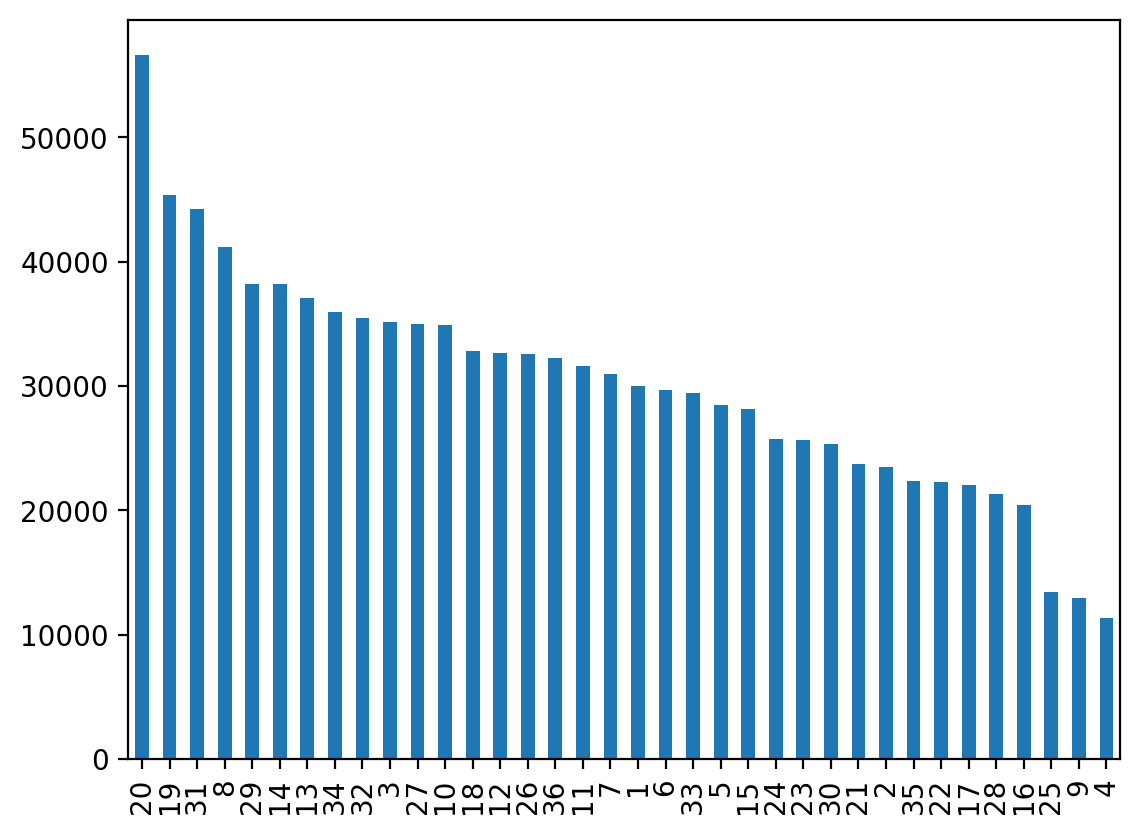

In [54]:
# 사용자별 데이터 수집량 보기
df['user-id'].value_counts().plot(kind='bar')

In [55]:
df["user-id"].nunique()

36

In [56]:
df['activity'].value_counts()

Walking       418395
Jogging       336450
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

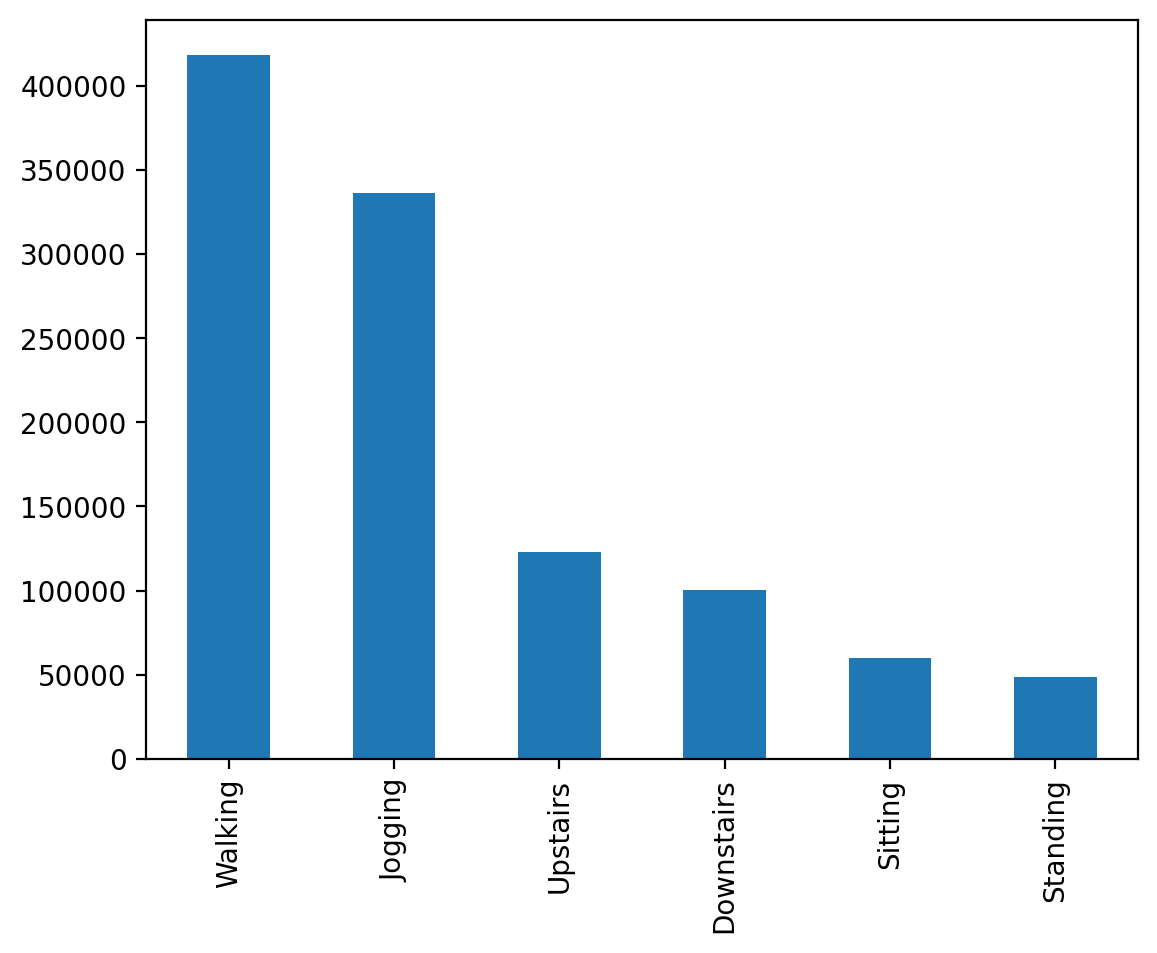

In [57]:
df['activity'].value_counts().plot(kind='bar')
plt.show()

<Axes: >

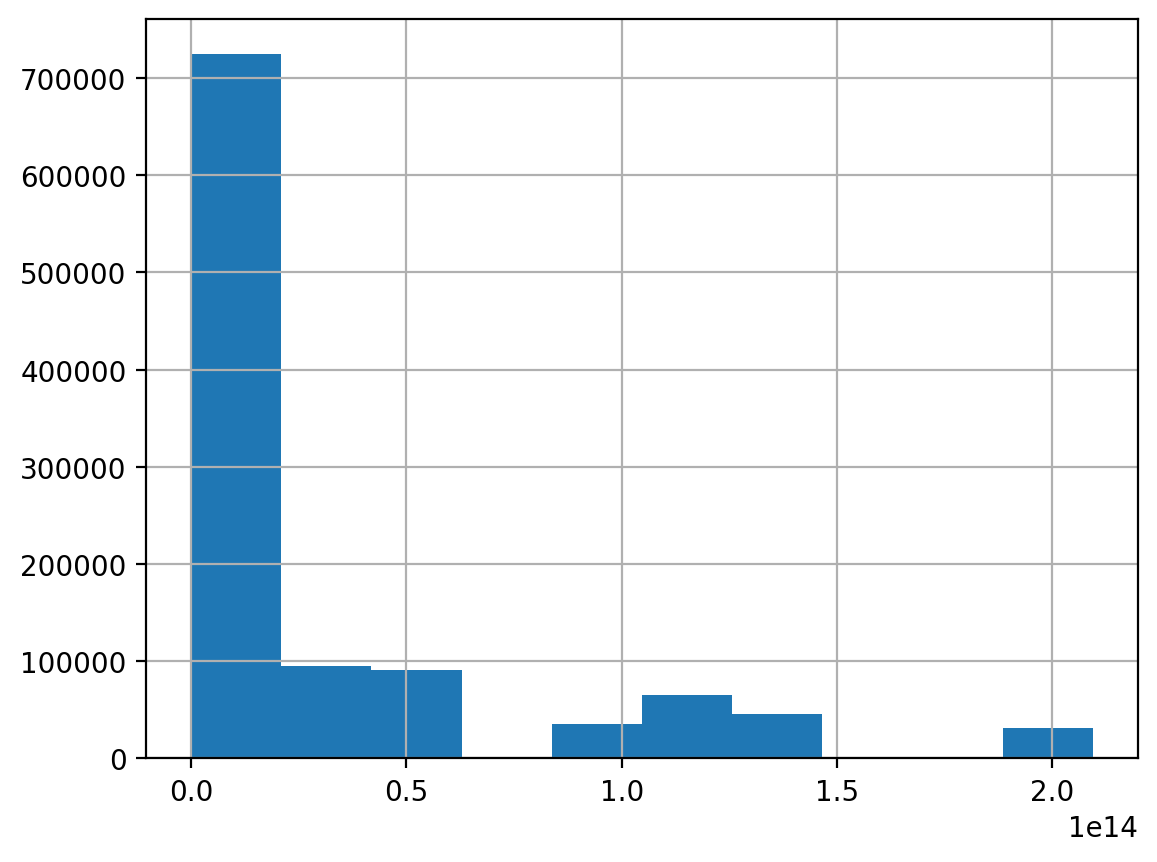

In [58]:
df['timestamp'].hist()

In [59]:
(df['timestamp'] == 0).sum()

12845

In [60]:
# 시각이 0이거나 음수인 샘플은 제외 (양수인 값만 사용)
df = df[df['timestamp'] > 0]
df.shape

(1073630, 6)

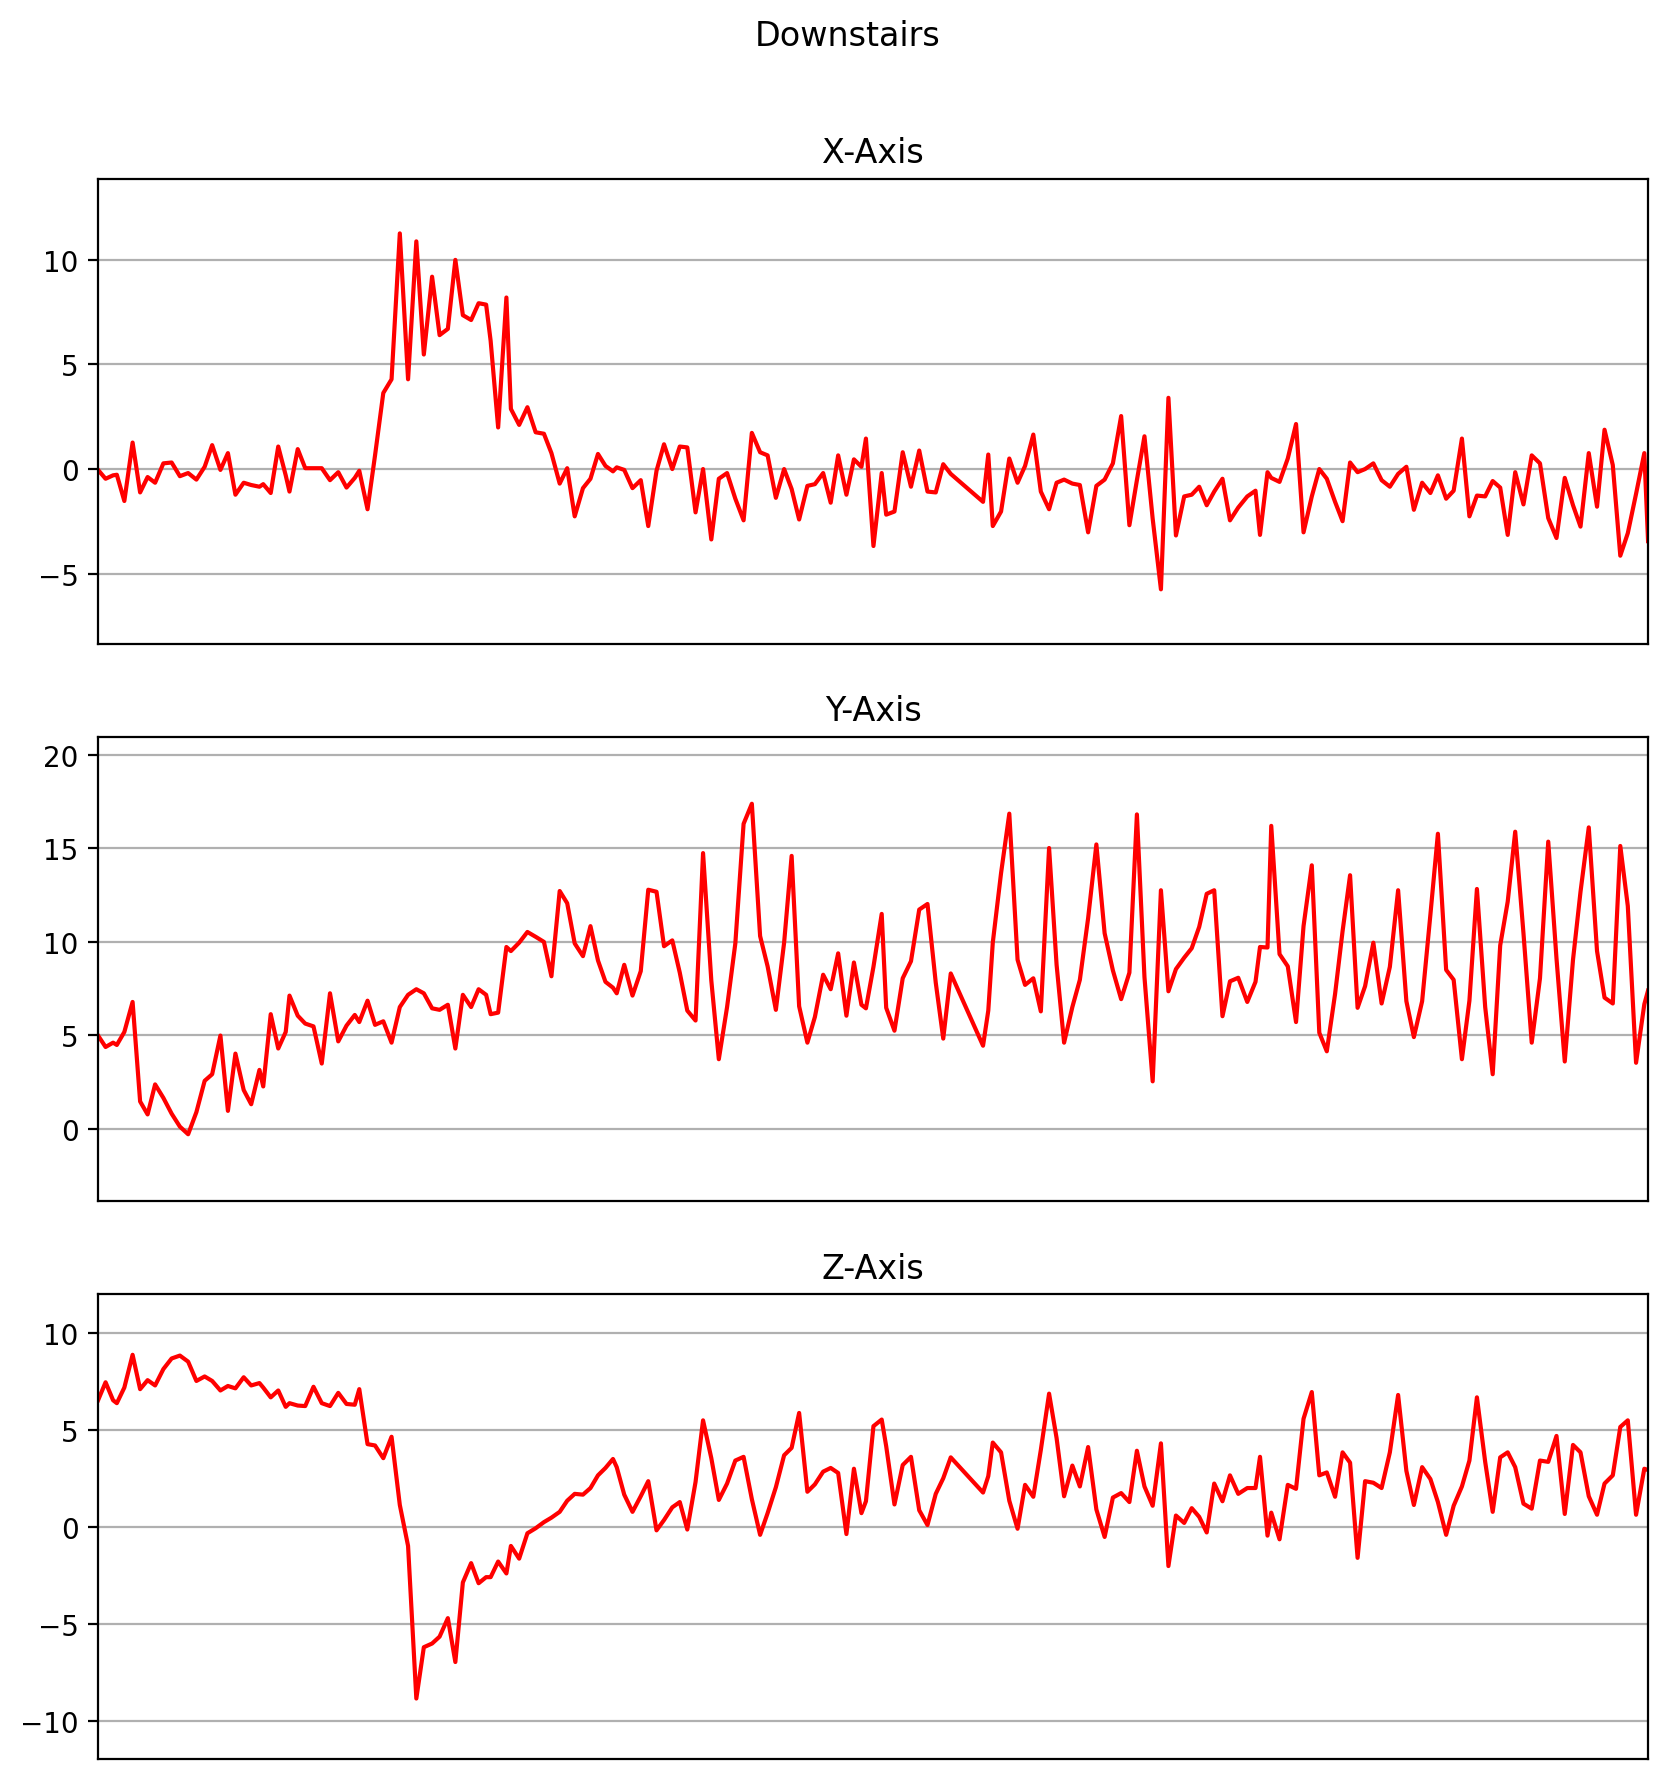

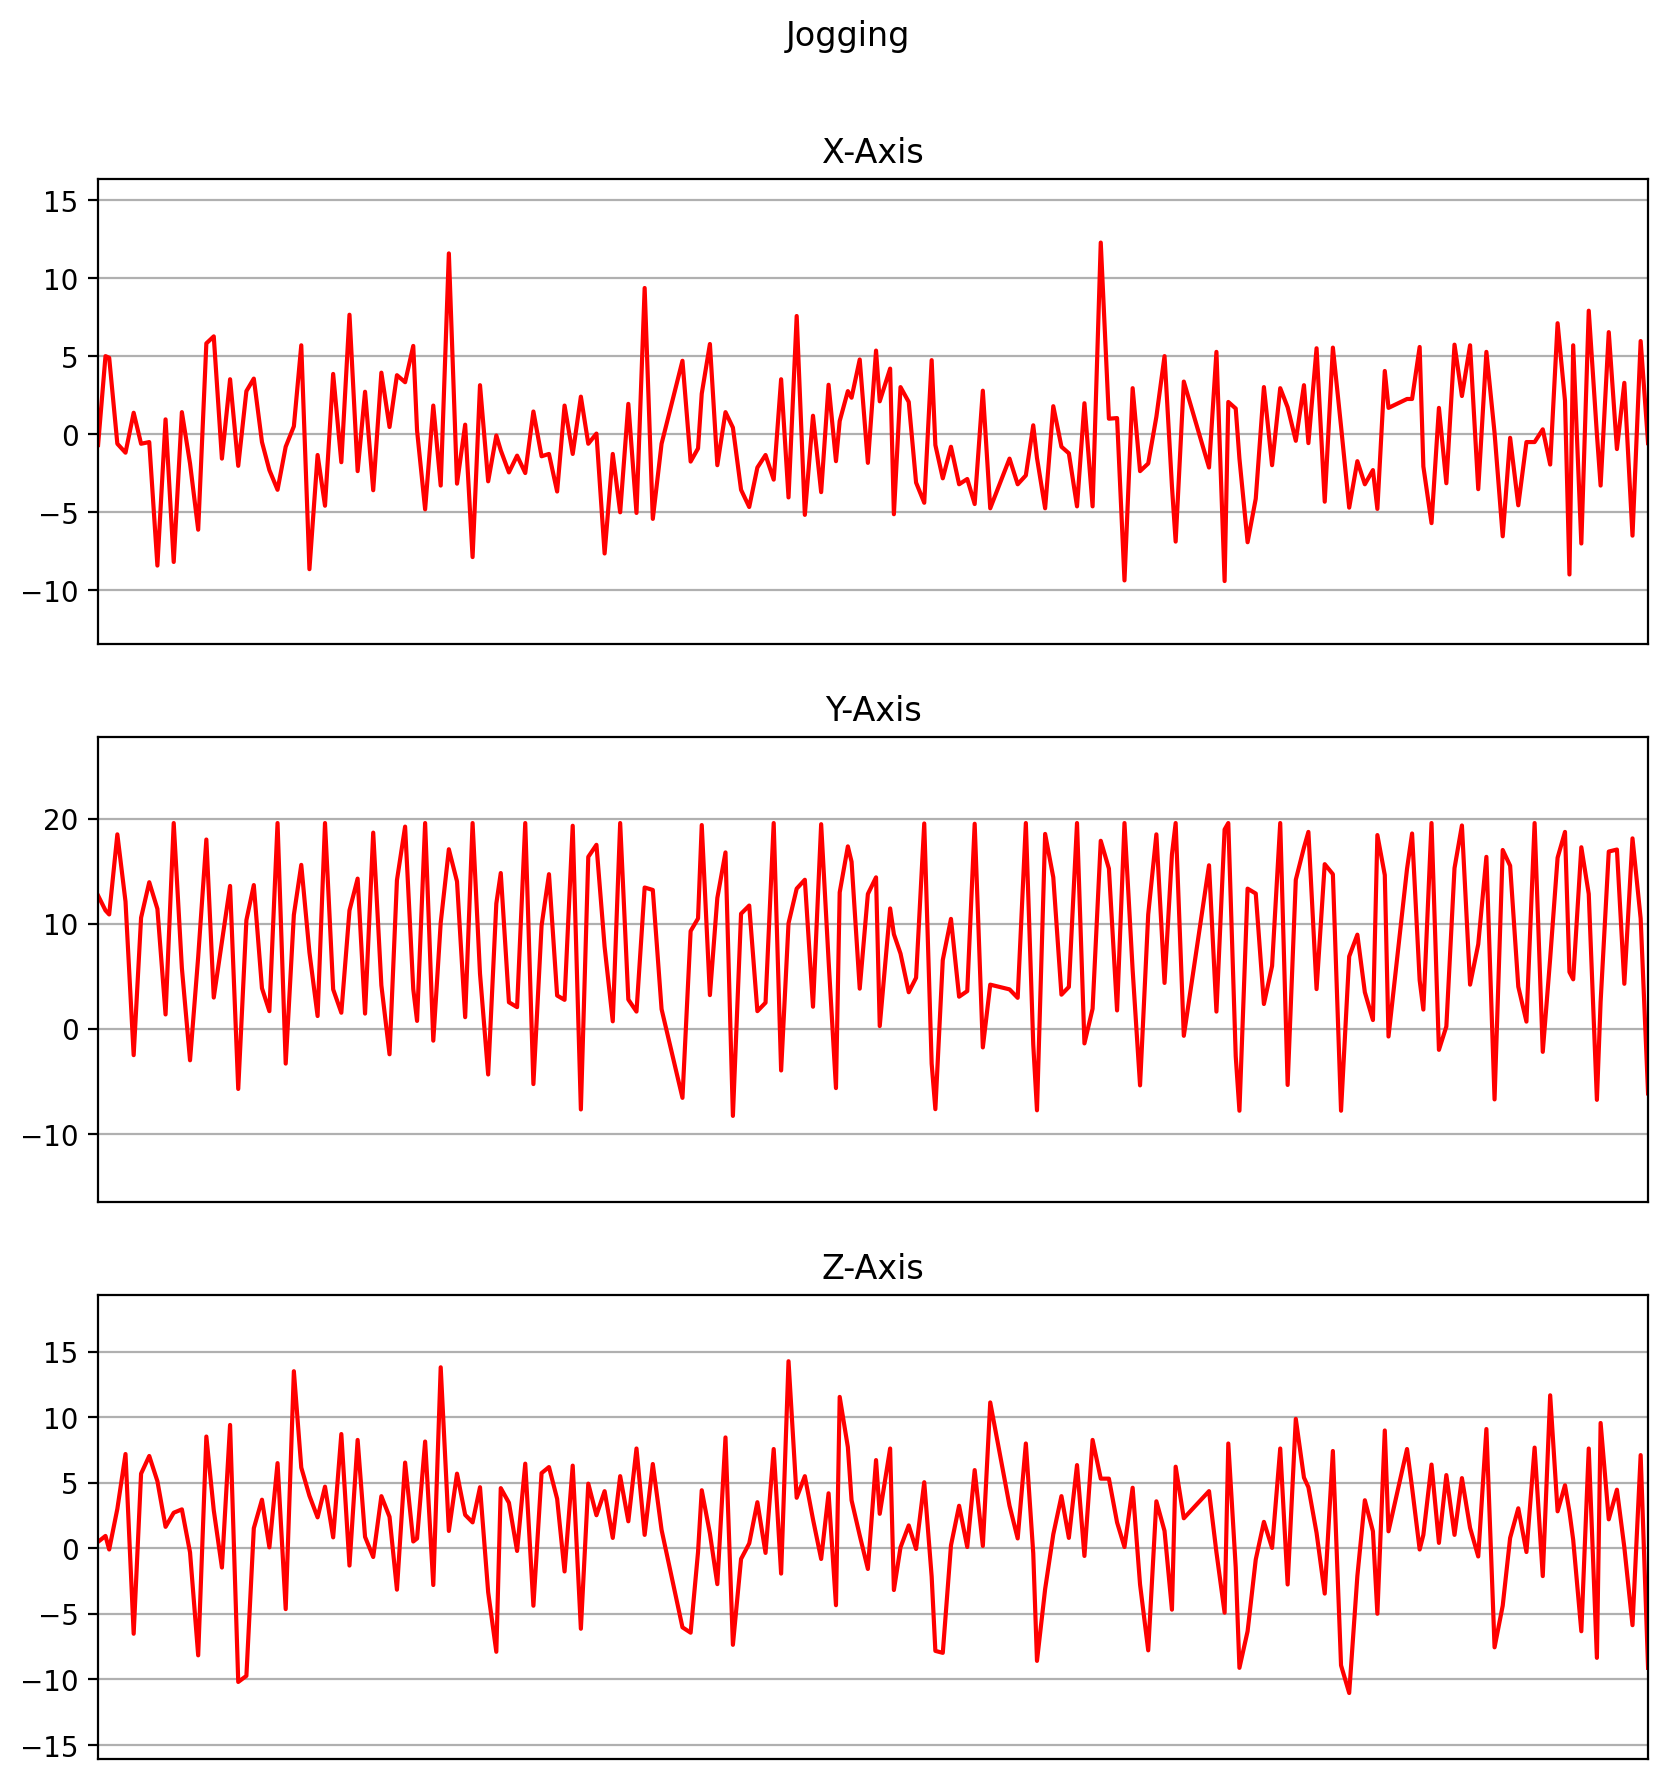

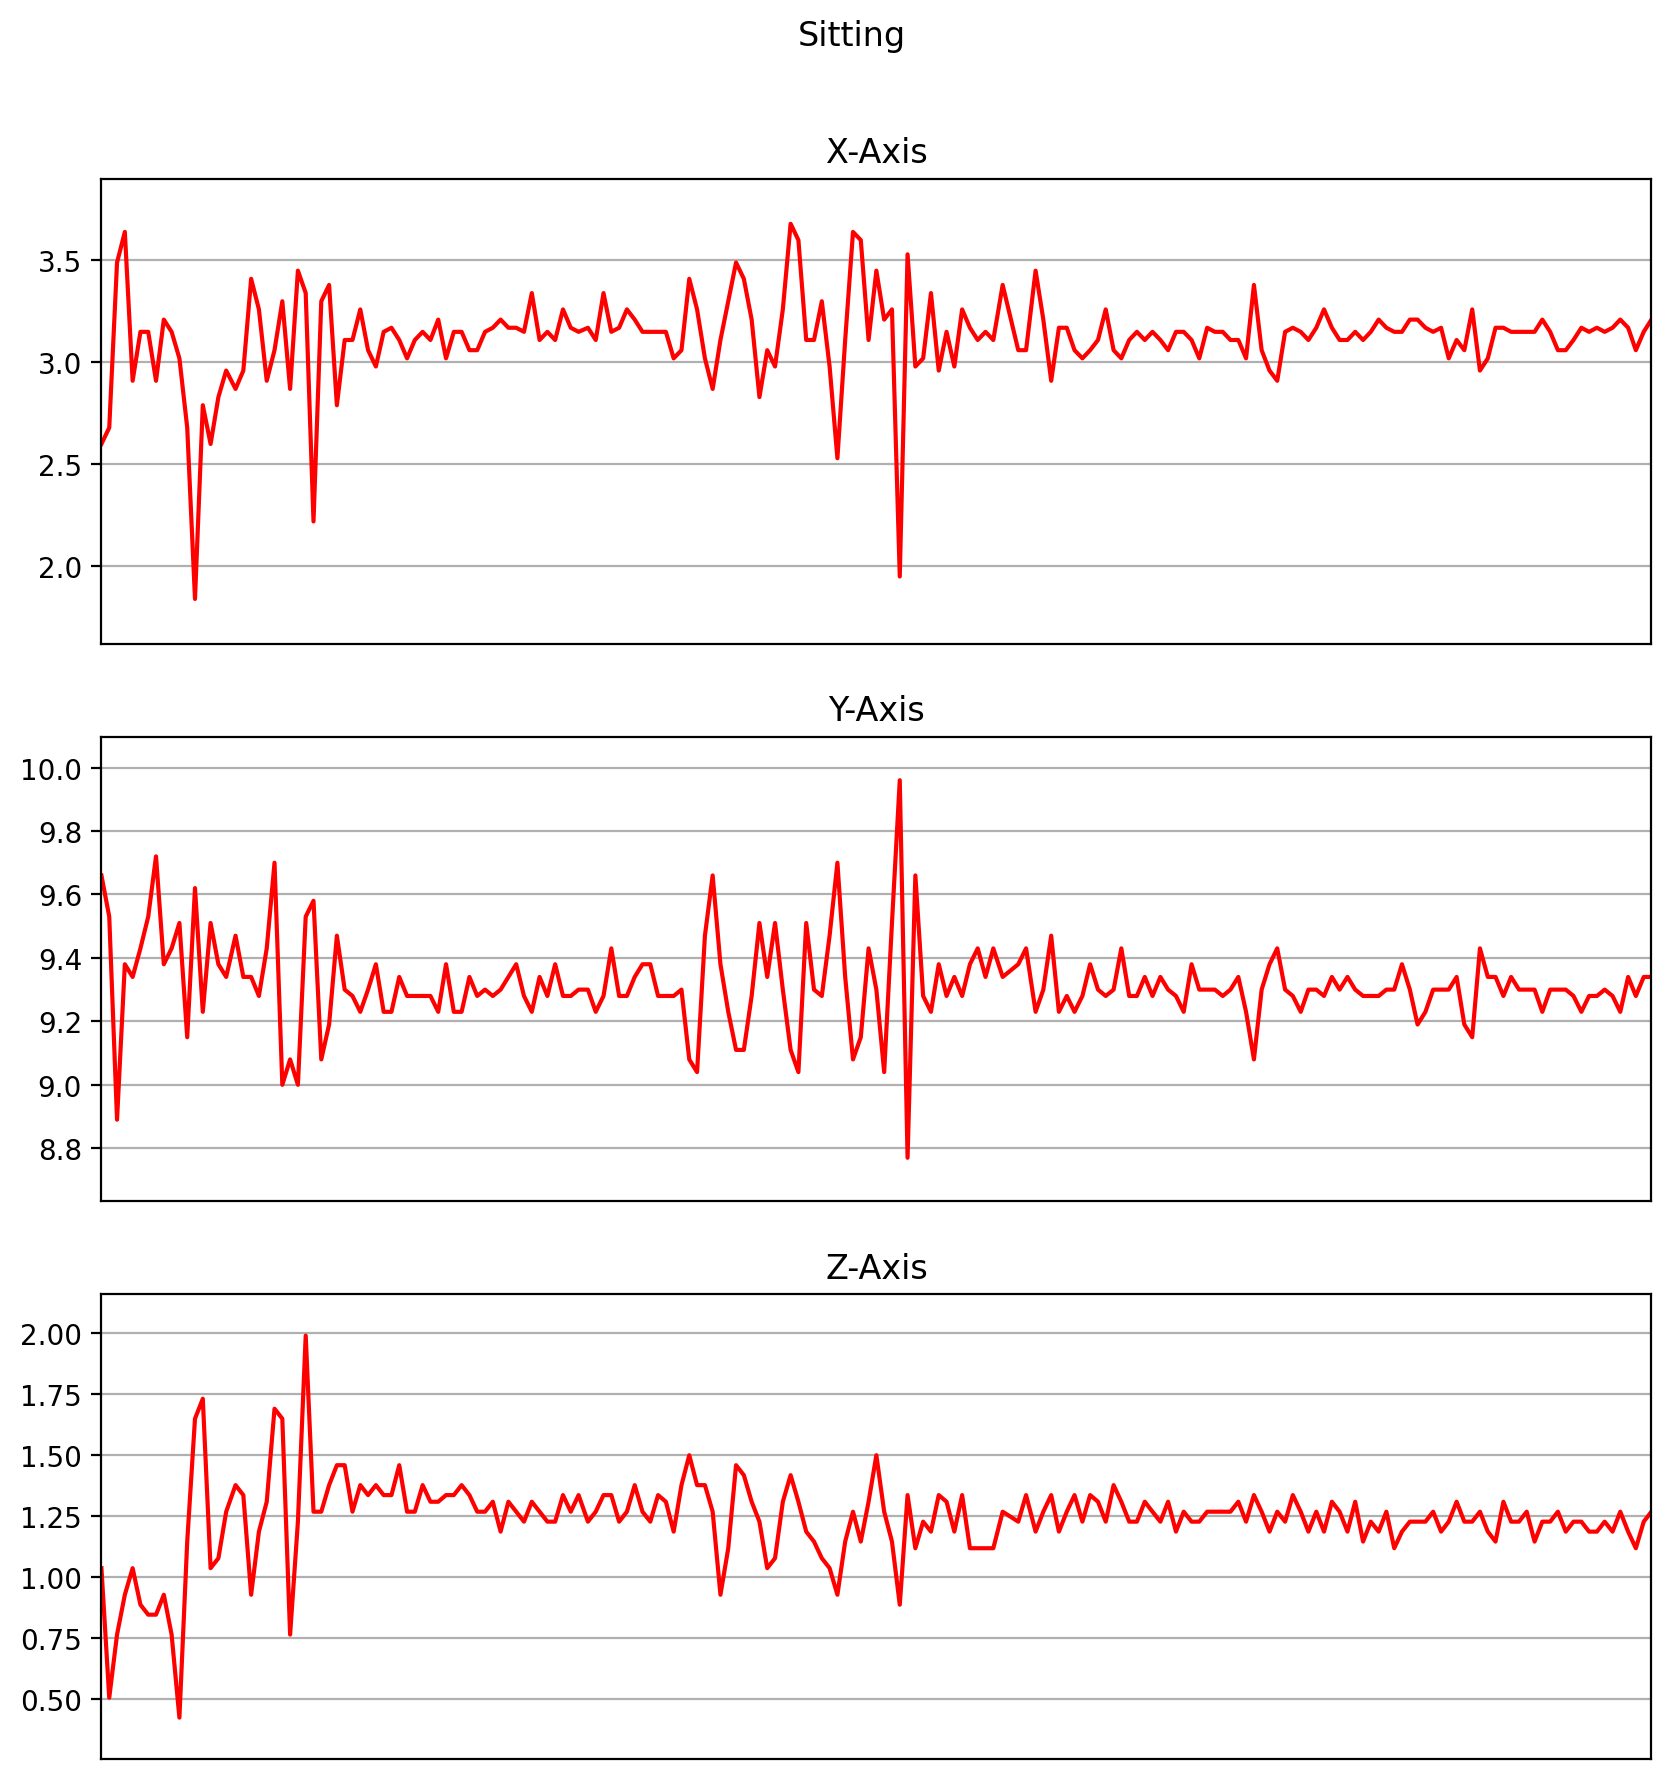

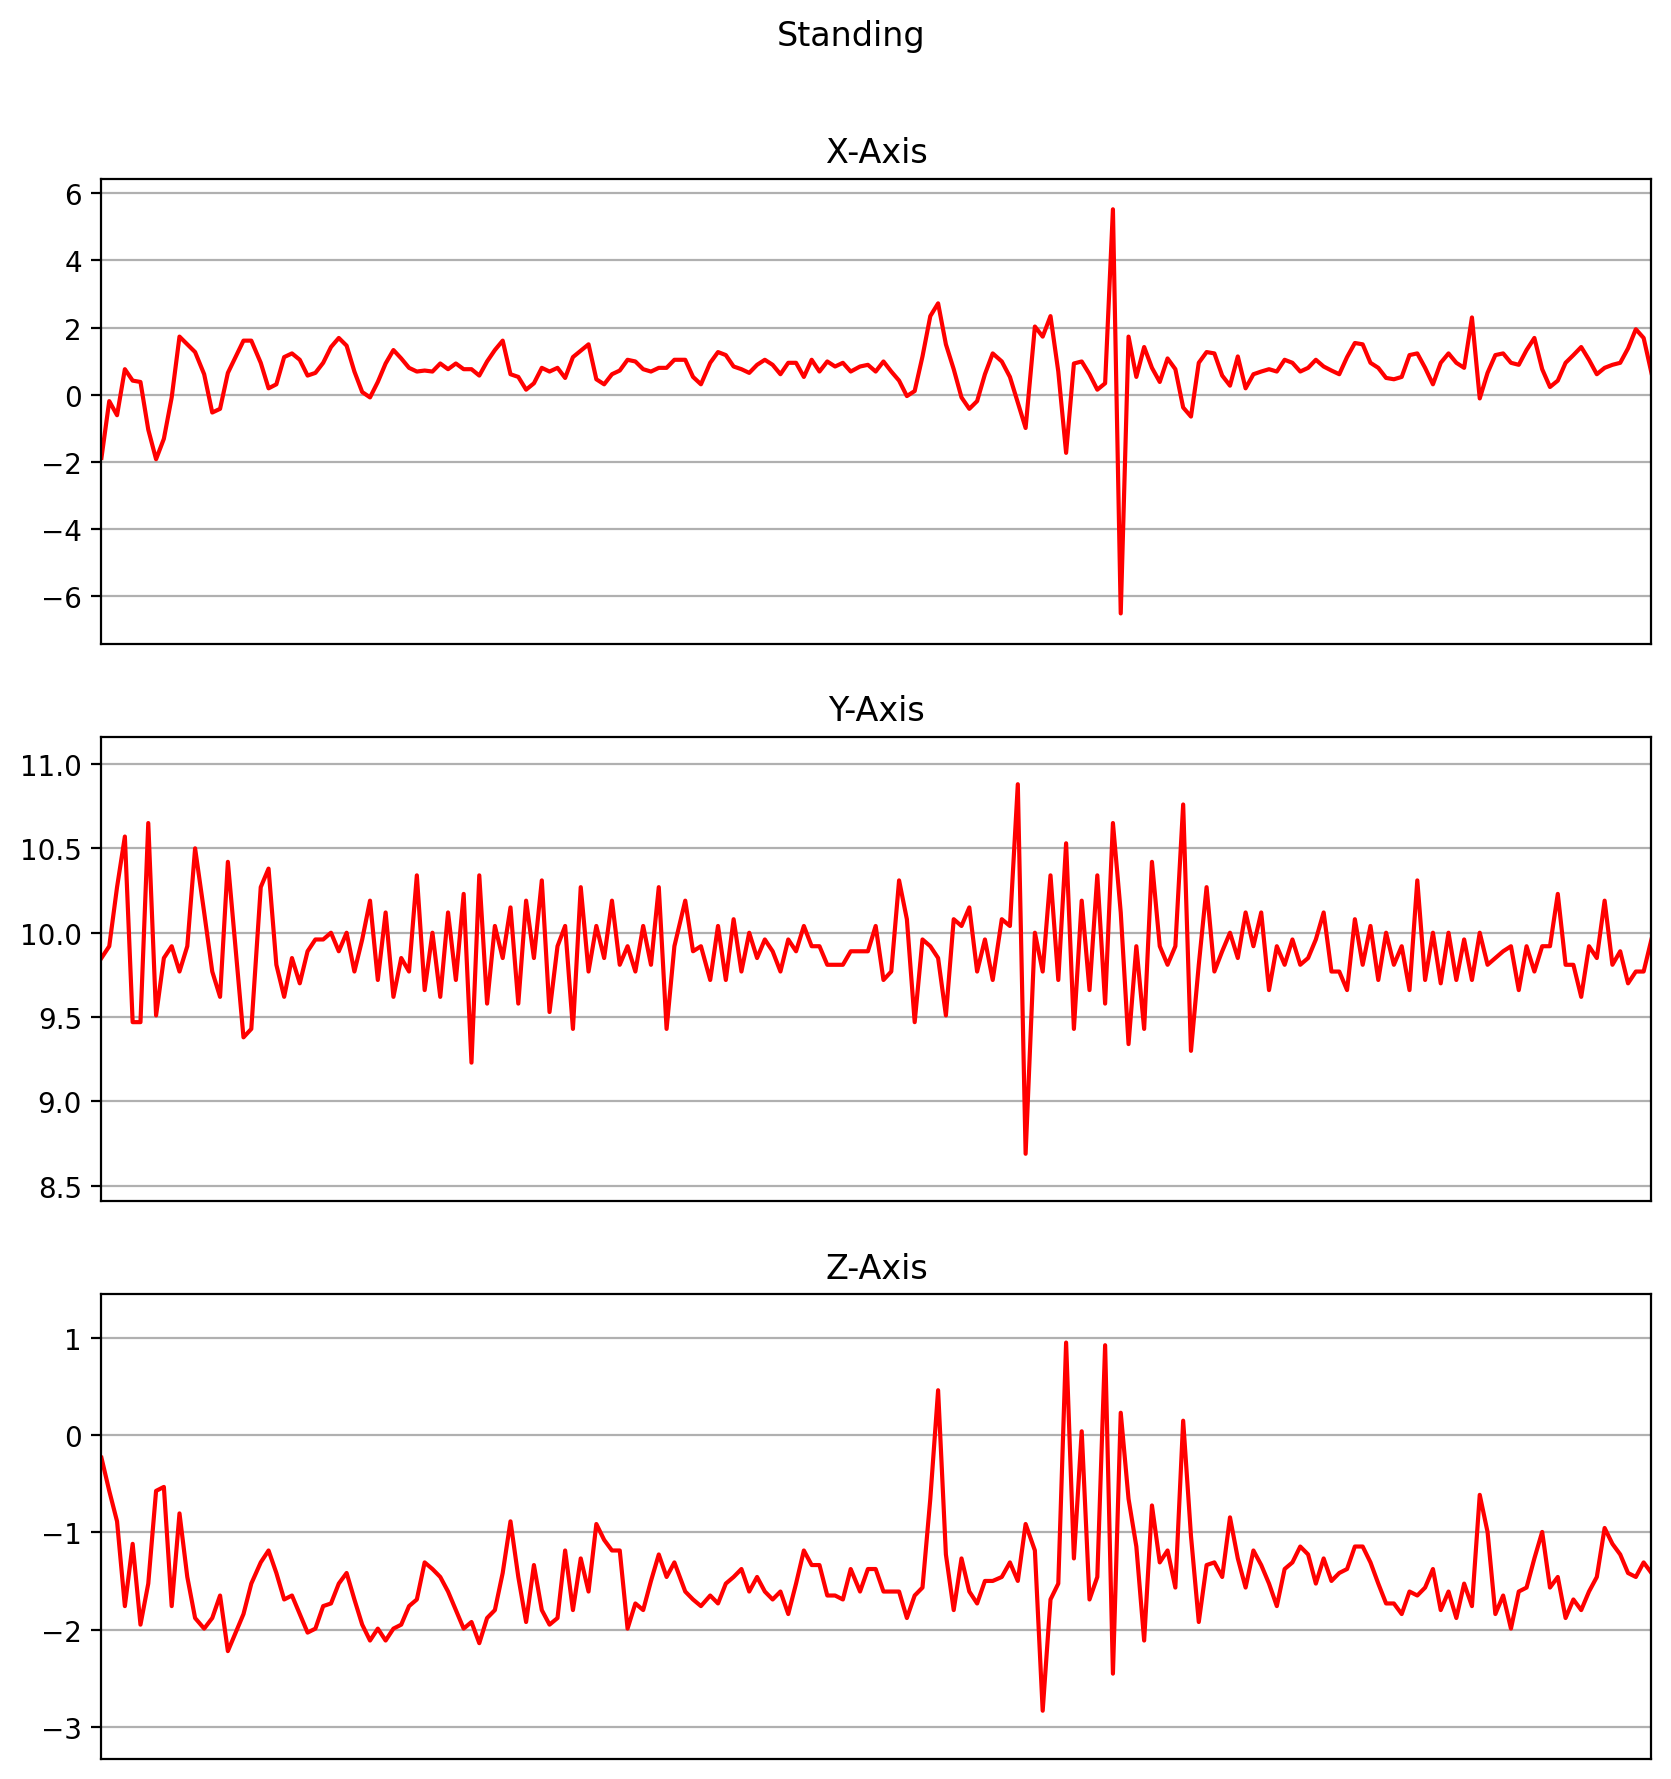

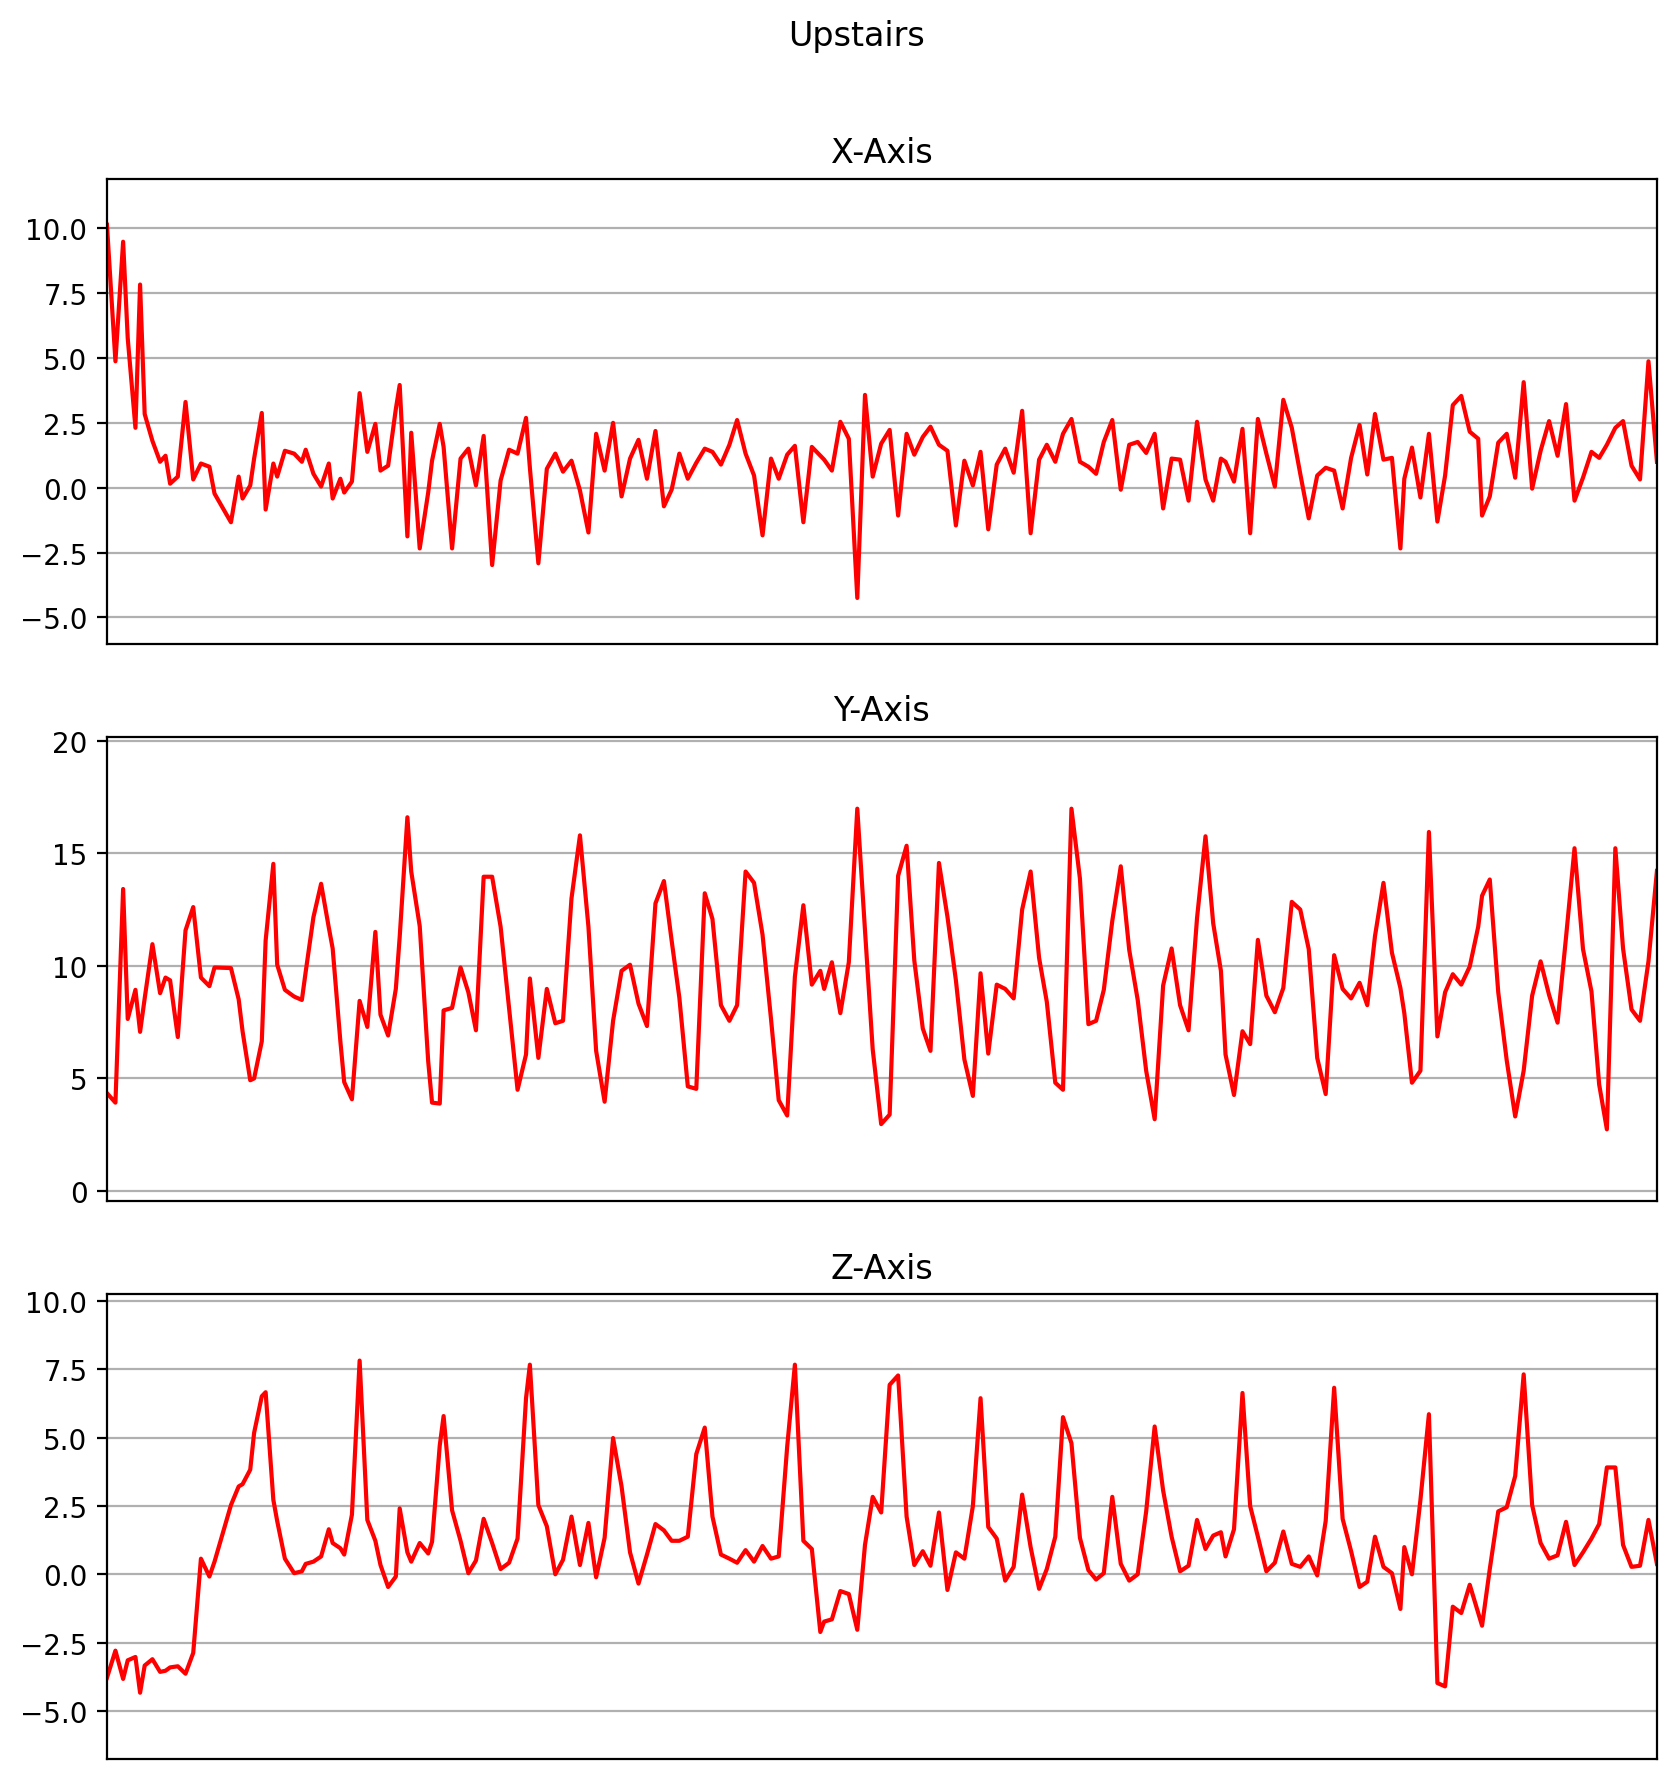

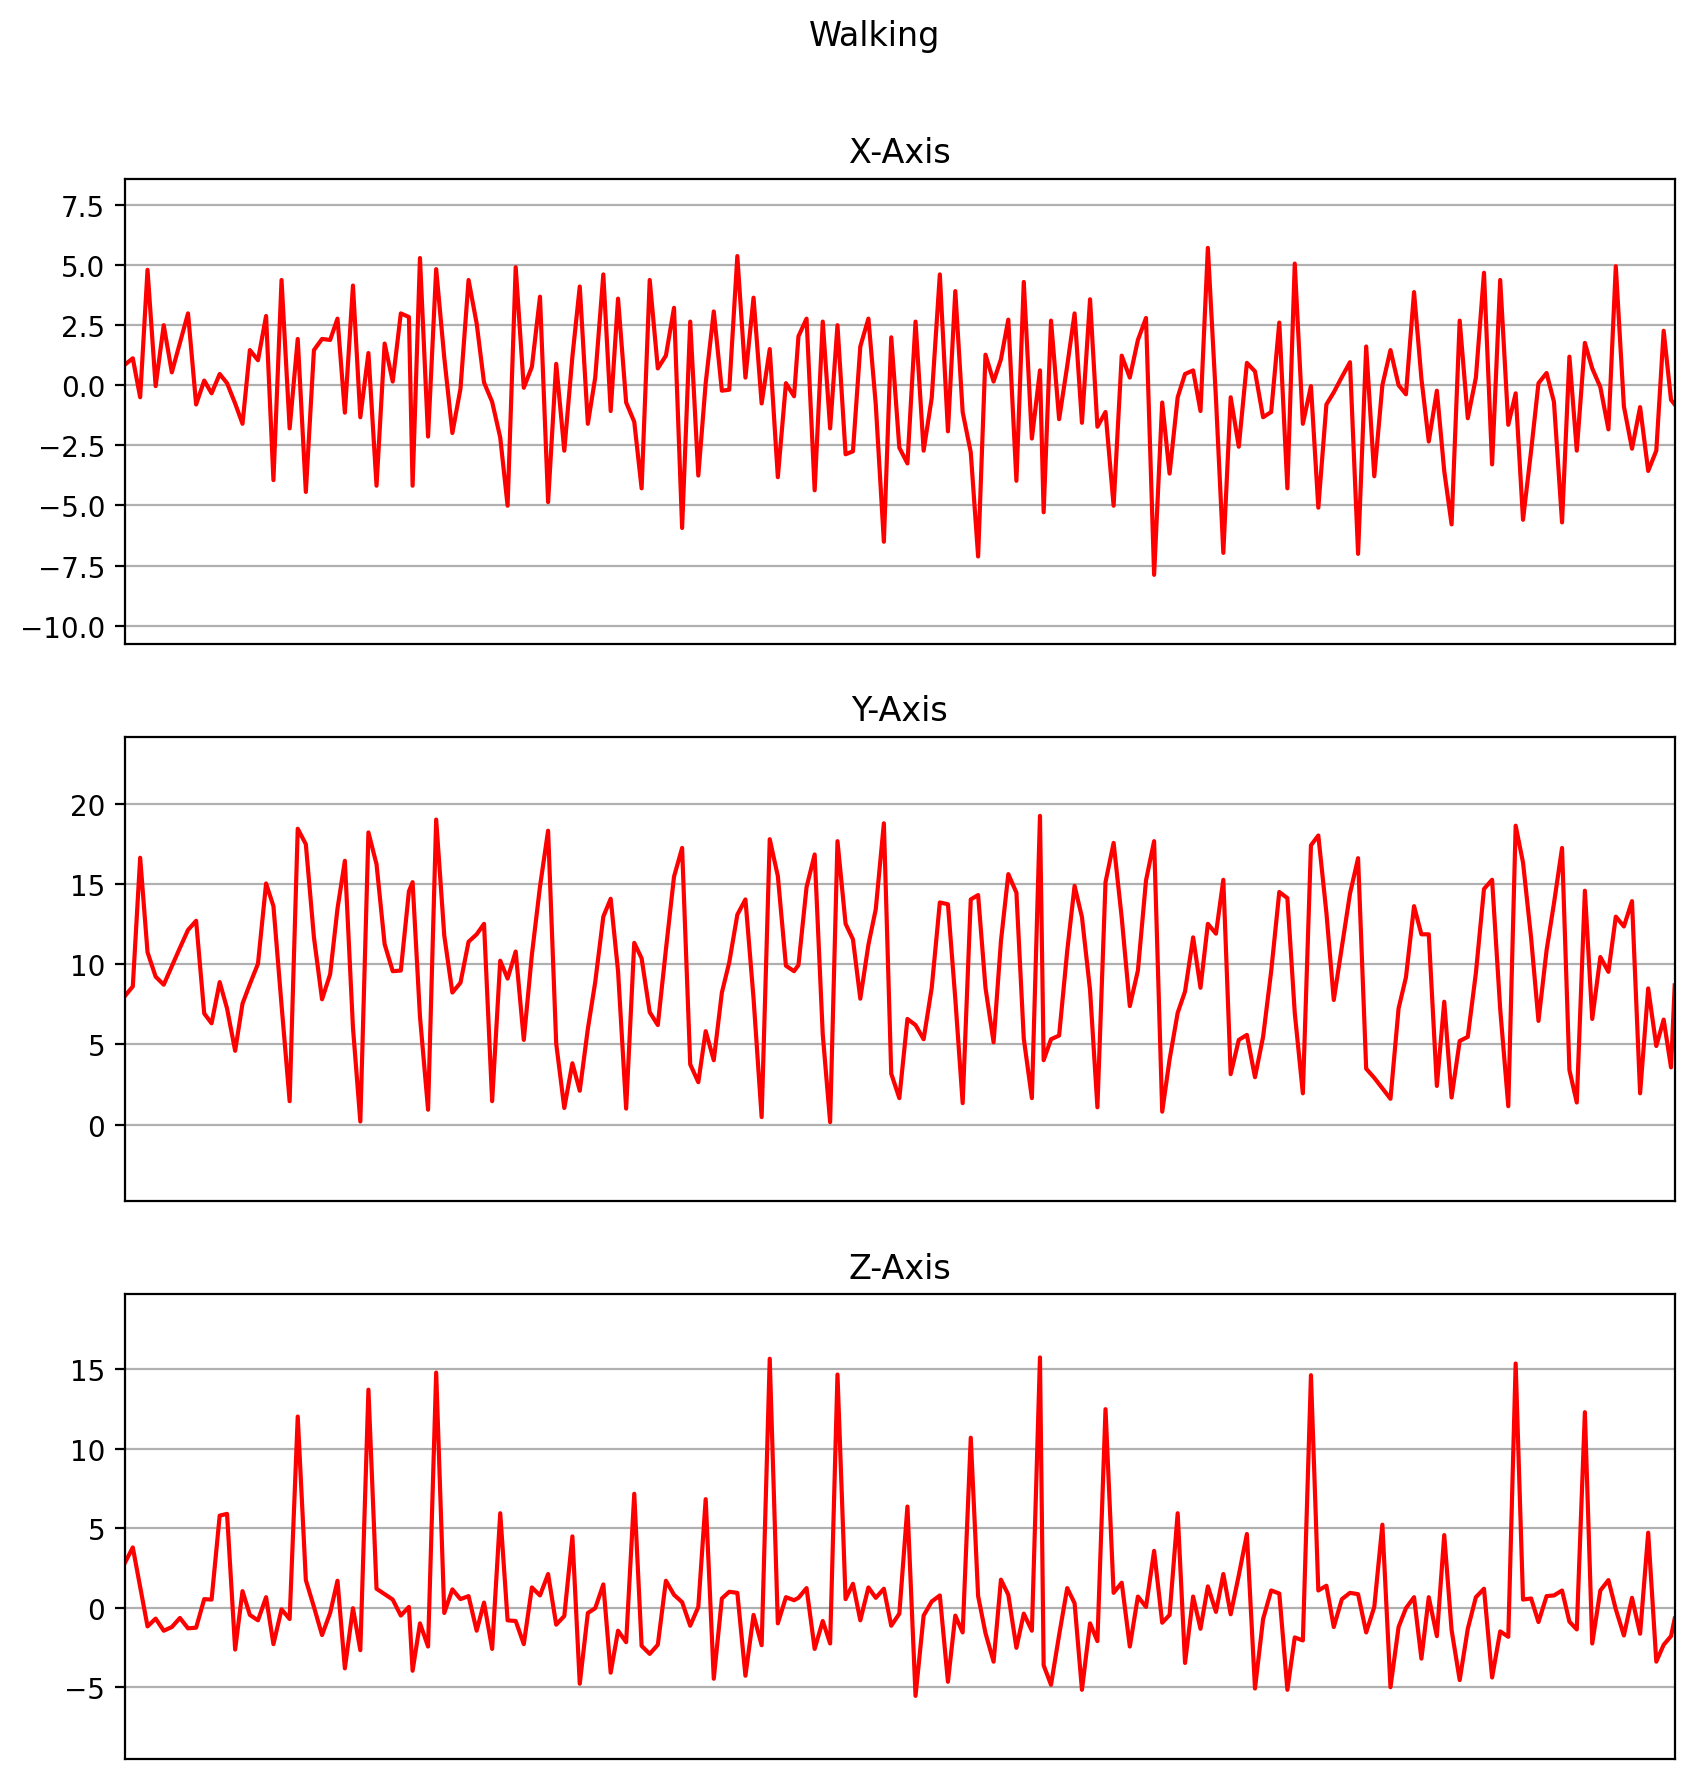

In [61]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10,10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:200]
    plot_activity(activity, subset)

In [62]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)

In [63]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


# 일정 기간동안 (윈도우)의 행동이 유지되는 것을 파악
- 현재 샘플링 시간은 50ms임
- 윈도우 크기를 100으로 잡으면 5초 동안 동일한 행동을 유지하는 경우만 취하게 됨
- stat 모듈이 제공하는 mode() 함수를 사용하여 최빈값을 구하고 이것이 100 인 경우의 데이터만 사용함 (동일한 행동을 5초간 유지하였는지를 파악함)

In [64]:
test = [1,1,1,1,1,1,1,1,1,1,1,1,2,2]
m = stats.mode(test) # 최빈값
m

<ipython-input-64-9ae1359be639>:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  m = stats.mode(test) # 최빈값


ModeResult(mode=array([1]), count=array([12]))

In [65]:
m[1][0]

12

In [66]:
m[0][0], m[1][0]

(1, 12)

In [67]:
z = stats.mode(df['act'][100:200]) # 5초간 관찰
z[0][0], z[1][0]

<ipython-input-67-56814aaff5d9>:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  z = stats.mode(df['act'][100:200]) # 5초간 관찰


(1, 100)

## 스케일링

In [68]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [69]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.197590,0.794280,0.021188,1
1,33,Jogging,49106062271000,0.627483,0.583895,0.115037,1
2,33,Jogging,49106112167000,0.611730,0.527252,-0.101100,1
3,33,Jogging,49106222305000,-0.185775,1.658075,0.547311,1
4,33,Jogging,49106332290000,-0.268479,0.709317,1.420390,1


## 훈련 데이터 검증 데이터 나누기
- 사용자를 기준으로 나누는 경우

In [70]:
(df['user-id'] < 28).mean()

0.7382683047232287

In [71]:
(df['user-id'] >= 28).mean()

0.2617316952767713

In [72]:
df_train = df[df['user-id'] < 28]
df_test = df[df['user-id'] >= 28]
# 랜덤하게 사용자를 선택하려면 choice() 사용

In [78]:
p = np.arange(30)
p.reshape(3,10).T

array([[ 0, 10, 20],
       [ 1, 11, 21],
       [ 2, 12, 22],
       [ 3, 13, 23],
       [ 4, 14, 24],
       [ 5, 15, 25],
       [ 6, 16, 26],
       [ 7, 17, 27],
       [ 8, 18, 28],
       [ 9, 19, 29]])

In [73]:
def get_xy(N, df): # N  윈도우 크기 (100)
    X, y = [], []
    for i in range(0, len(df)-N+1, N):
        z = stats.mode(df['act'][i: i+N])
        action, count = z[0][0], z[1][0]
        if count == N:
            xs = df['x-axis'].values[i: i + N]
            ys = df['y-axis'].values[i: i + N]
            zs = df['z-axis'].values[i: i + N]
            X.append(np.array([xs, ys, zs]).T)
            y.append(action)
    return np.array(X), np.array(y)

In [74]:
N = 100
X_train, y_train = get_xy(N, df_train)

<ipython-input-73-72d6b8cd2333>:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  z = stats.mode(df['act'][i: i+N])


In [35]:
X_test, y_test = get_xy(N, df_test)

<ipython-input-33-72d6b8cd2333>:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  z = stats.mode(df['act'][i: i+N])


In [36]:
X_train.shape, X_test.shape

((7637, 100, 3), (2713, 100, 3))

In [37]:
y_train.shape, y_test.shape

((7637,), (2713,))

In [38]:
# X_train[:1]

In [39]:
y_train[:3]

array([5, 5, 5])

In [40]:
def show_confusion_matrix(y_test, y_pred):
    matrix = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [41]:
def show_results(y_test, y_pred):
    show_confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))

# 선형 분류

In [42]:
lin = SGDClassifier()
lin.fit(X_train.reshape(-1,300), y_train)
lin.score(X_test.reshape(-1,300), y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.4076667895318835

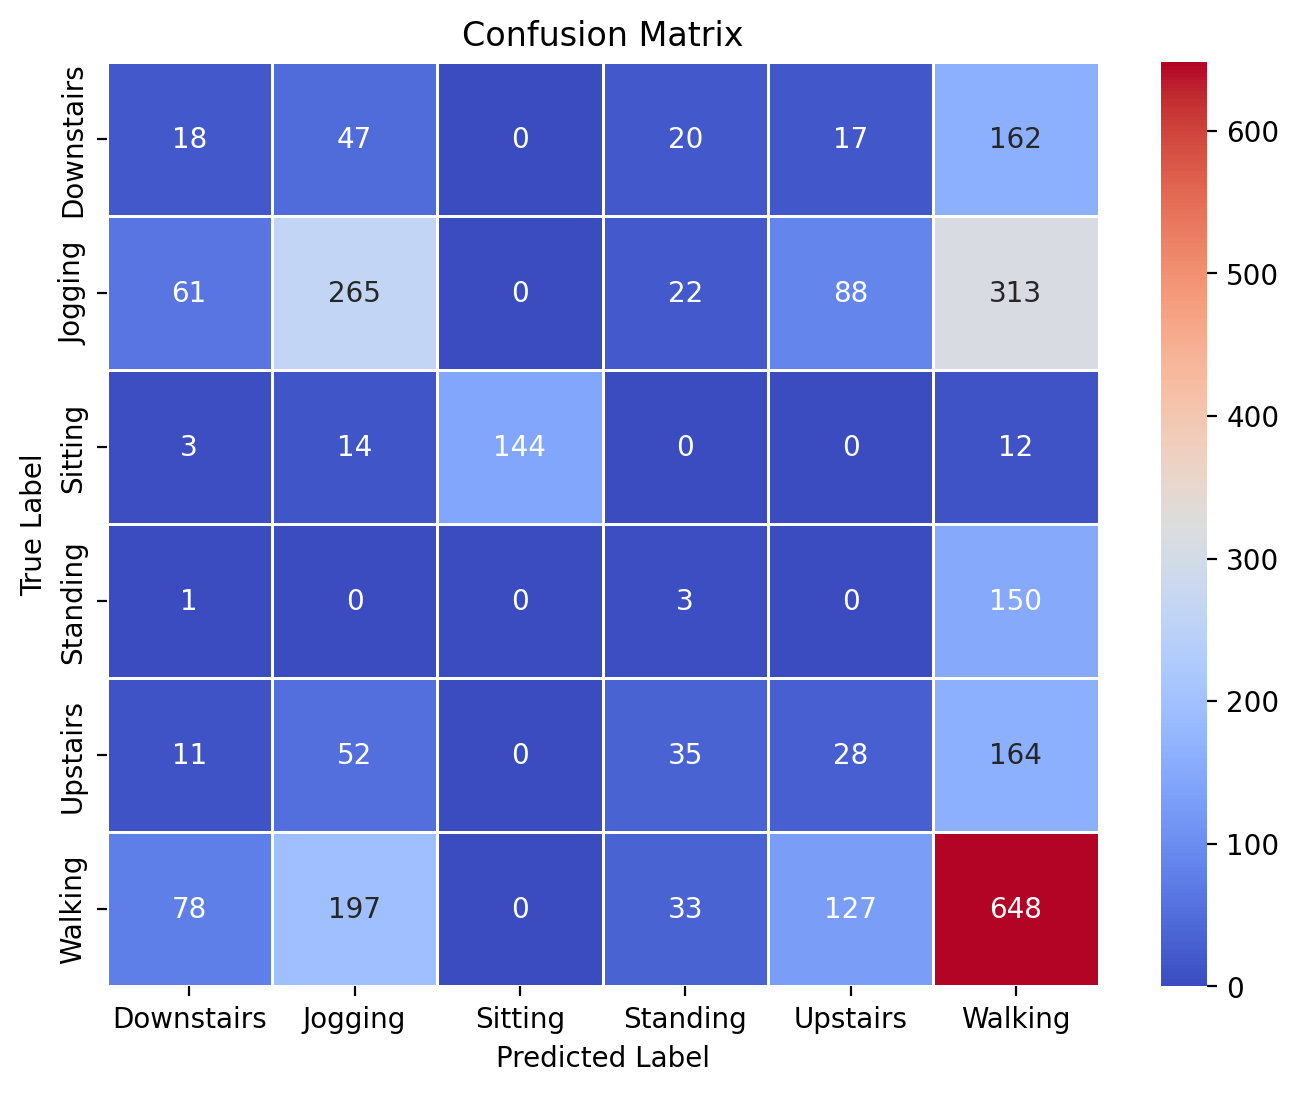

              precision    recall  f1-score   support

           0       0.10      0.07      0.08       264
           1       0.46      0.35      0.40       749
           2       1.00      0.83      0.91       173
           3       0.03      0.02      0.02       154
           4       0.11      0.10      0.10       290
           5       0.45      0.60      0.51      1083

    accuracy                           0.41      2713
   macro avg       0.36      0.33      0.34      2713
weighted avg       0.39      0.41      0.39      2713



In [43]:
y_pred = lin.predict(X_test.reshape(-1,300))
show_results(y_test, y_pred)

## 랜덤 포레스트

In [79]:
rfc = RandomForestClassifier()
# rfc.fit(X_train.reshape(-1,300), y_train_cat)
# rfc.score(X_test.reshape(-1,300), y_test_cat)
rfc.fit(X_train.reshape(-1,300), y_train)
rfc.score(X_test.reshape(-1,300), y_test)

0.7475119793586436

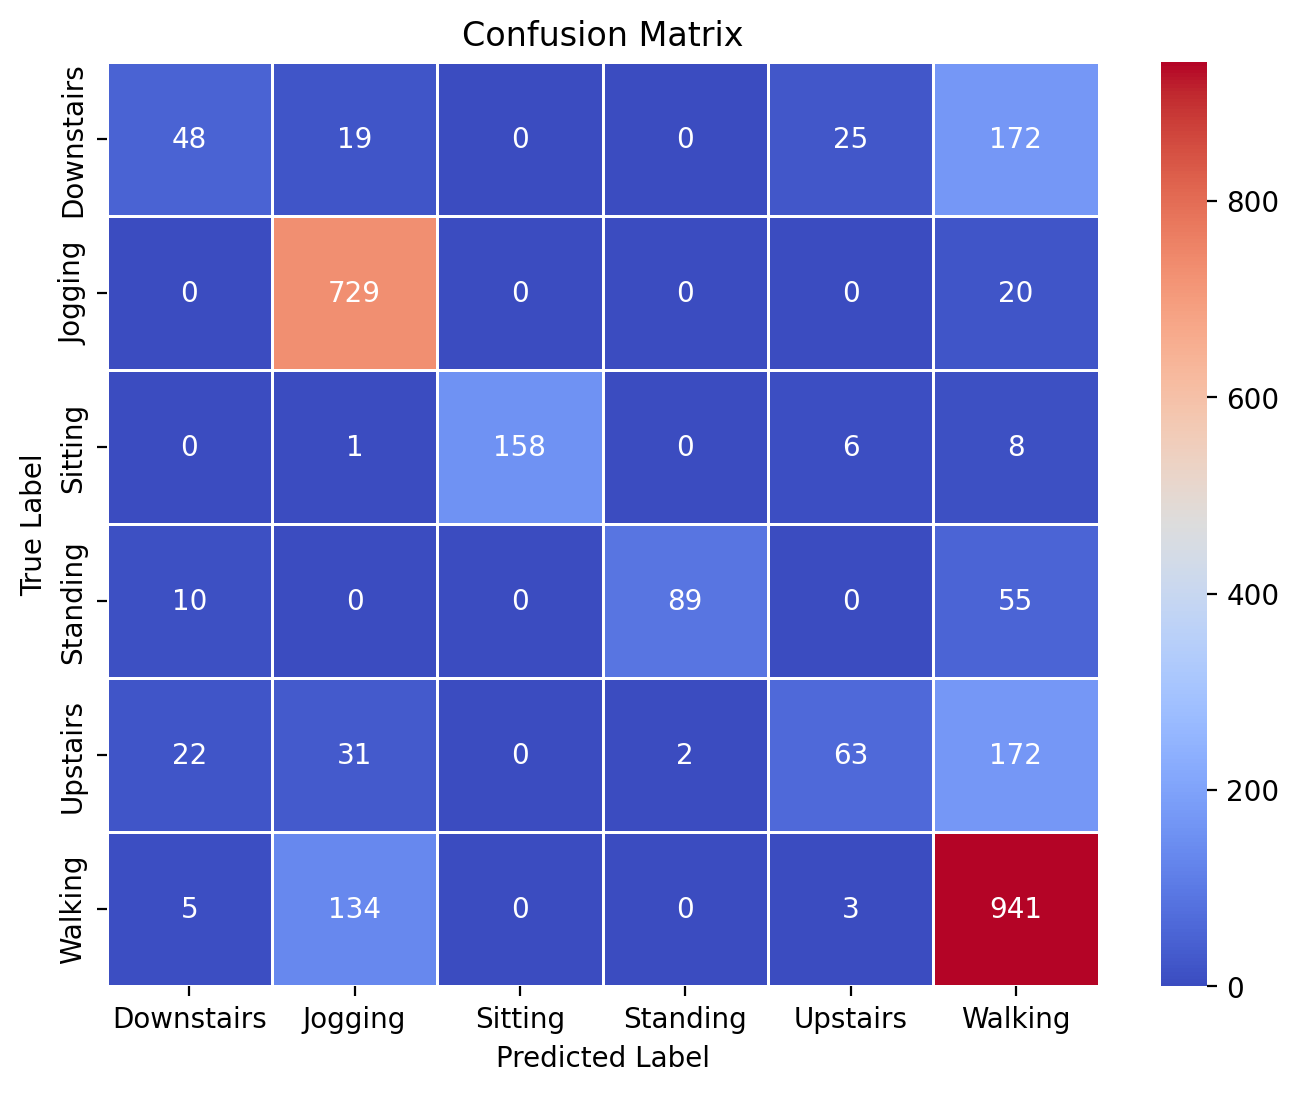

              precision    recall  f1-score   support

           0       0.56      0.18      0.28       264
           1       0.80      0.97      0.88       749
           2       1.00      0.91      0.95       173
           3       0.98      0.58      0.73       154
           4       0.65      0.22      0.33       290
           5       0.69      0.87      0.77      1083

    accuracy                           0.75      2713
   macro avg       0.78      0.62      0.65      2713
weighted avg       0.74      0.75      0.71      2713



In [80]:
y_pred = rfc.predict(X_test.reshape(-1,300))
show_results(y_test, y_pred)

# 목적변수를 원핫 인코딩으로 변경

In [81]:
# 원 핫 인코딩
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)
y_train_cat[:3]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

# MLP

In [82]:
model_m = Sequential()
model_m.add(Reshape((N*3,),input_shape=(N,3)))
model_m.add(Dense(200, activation='relu',input_shape=(N*3,)))
model_m.add(Dropout(0.5))
model_m.add(Dense(200, activation='relu'))
model_m.add(Dropout(0.5))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))
# model_m.summary()

In [83]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# 레이블로 원 핫 인코딩을 사용해야 한다
h = model_m.fit(X_train,
                      y_train_cat,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=0)

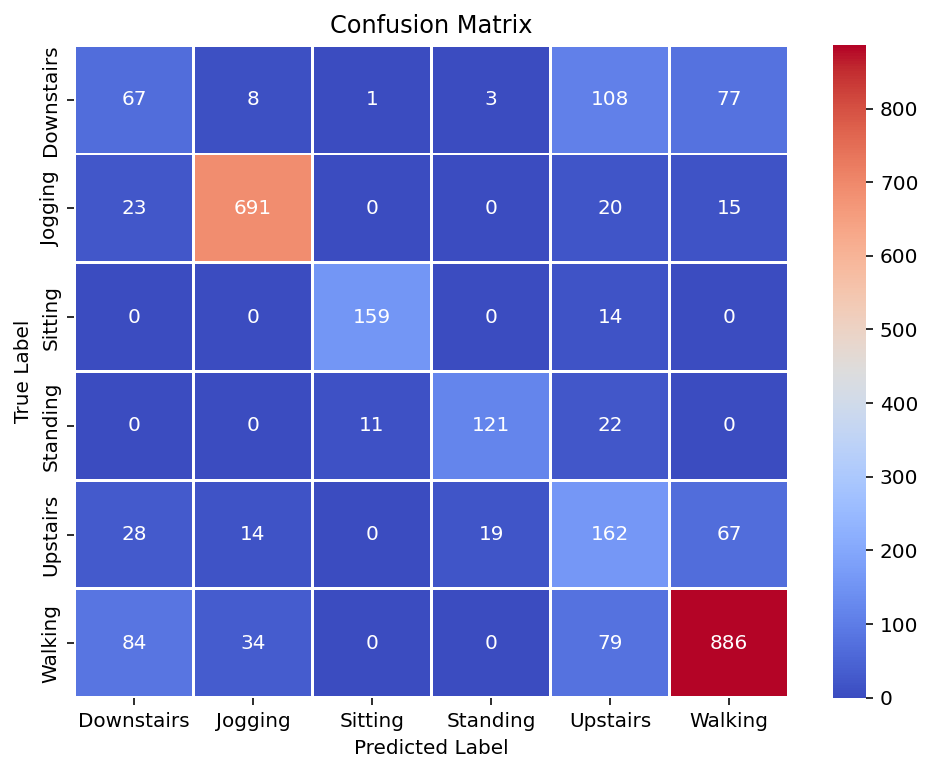

              precision    recall  f1-score   support

           0       0.33      0.25      0.29       264
           1       0.93      0.92      0.92       749
           2       0.93      0.92      0.92       173
           3       0.85      0.79      0.81       154
           4       0.40      0.56      0.47       290
           5       0.85      0.82      0.83      1083

    accuracy                           0.77      2713
   macro avg       0.71      0.71      0.71      2713
weighted avg       0.78      0.77      0.77      2713



In [ ]:
y_pred = model_m.predict(X_test)

# 원핫 인코딩을 레이블 인코딩으로 변환
max_y_pred = np.argmax(y_pred, axis=1)
show_results(y_test, max_y_pred)

In [88]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

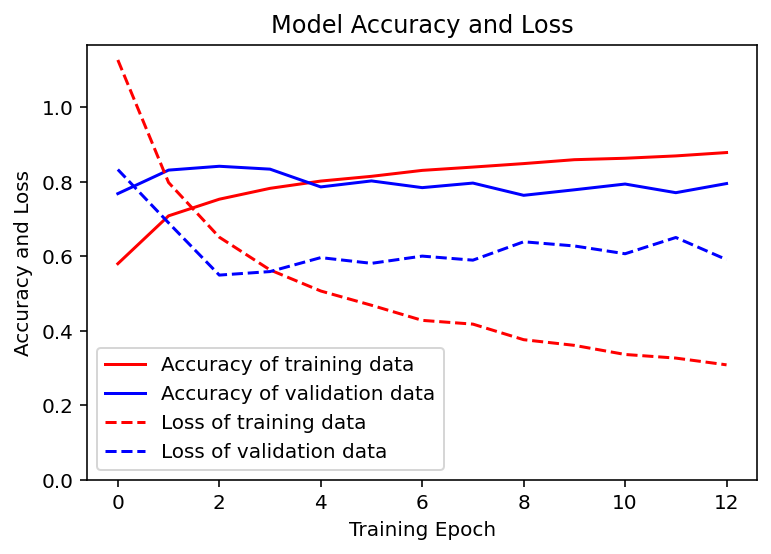

In [ ]:
show_4_graphs(h)

# CNN (Conv1D)

In [113]:
# (sample, shape, features) 구조 사용
model_cnn = Sequential()
model_cnn.add(Conv1D(32, 8, activation='relu',input_shape=(N,3)))
model_cnn.add(Dropout(0.3))
model_cnn.add(Conv1D(32, 8, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(16, 8, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(8, 8, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(6, activation='softmax'))
model_cnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, 93, 32)            800       
                                                                 
 dropout_35 (Dropout)        (None, 93, 32)            0         
                                                                 
 conv1d_45 (Conv1D)          (None, 86, 32)            8224      
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 43, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_46 (Conv1D)          (None, 36, 16)            4112      
                                                                 
 dropout_36 (Dropout)        (None, 36, 16)            0         
                                                     

In [114]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)]
model_cnn.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_cnn.fit(X_train,
                      y_train_cat,
                      batch_size=30,
                      epochs=50,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
204/204 [==============================] - 5s 12ms/step - loss: 1.0413 - accuracy: 0.5904 - val_loss: 0.6753 - val_accuracy: 0.8187
Epoch 2/50
204/204 [==============================] - 2s 9ms/step - loss: 0.5727 - accuracy: 0.7911 - val_loss: 0.5471 - val_accuracy: 0.8449
Epoch 3/50
204/204 [==============================] - 2s 8ms/step - loss: 0.4007 - accuracy: 0.8507 - val_loss: 0.5655 - val_accuracy: 0.8357
Epoch 4/50
204/204 [==============================] - 1s 7ms/step - loss: 0.3104 - accuracy: 0.8777 - val_loss: 0.6420 - val_accuracy: 0.8109
Epoch 5/50
204/204 [==============================] - 1s 7ms/step - loss: 0.2595 - accuracy: 0.8957 - val_loss: 0.8904 - val_accuracy: 0.7402
Epoch 6/50
204/204 [==============================] - 2s 8ms/step - loss: 0.2235 - accuracy: 0.9136 - val_loss: 0.9526 - val_accuracy: 0.7487


85/85 [==============================] - 1s 5ms/step


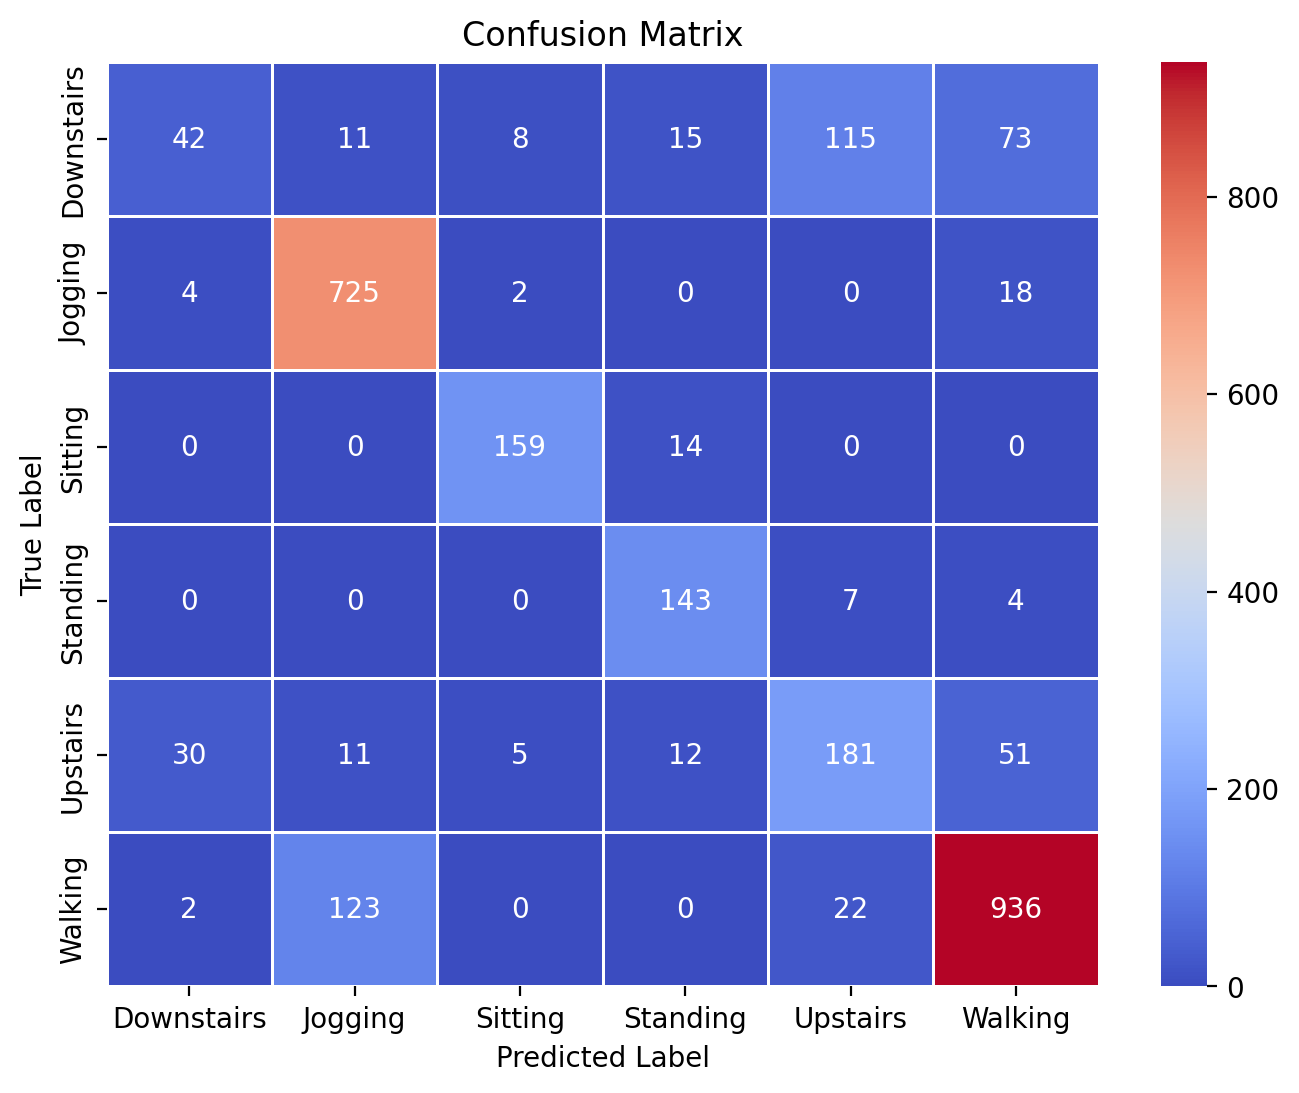

              precision    recall  f1-score   support

           0       0.54      0.16      0.25       264
           1       0.83      0.97      0.90       749
           2       0.91      0.92      0.92       173
           3       0.78      0.93      0.85       154
           4       0.56      0.62      0.59       290
           5       0.87      0.86      0.86      1083

    accuracy                           0.81      2713
   macro avg       0.75      0.74      0.73      2713
weighted avg       0.79      0.81      0.79      2713



In [98]:
y_pred = model_cnn.predict(X_test)

# 원핫 인코딩을 레이블 인코딩으로 변환
max_y_pred = np.argmax(y_pred, axis=1)
show_results(y_test, max_y_pred)

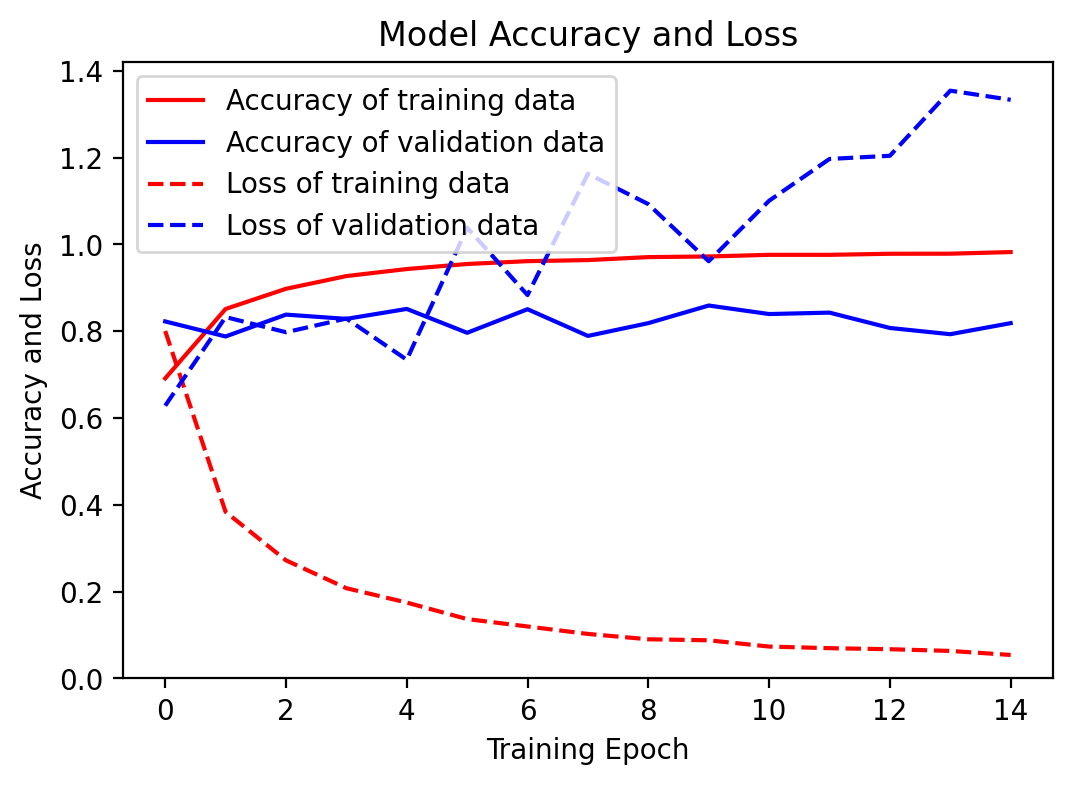

In [89]:
show_4_graphs(history)

# RNN

In [ ]:
from keras.layers import GRU
model_rnn = Sequential()
model_rnn.add(GRU(256, return_sequences=True, input_shape=(N,3)))
model_rnn.add(Dropout(0.2))
model_rnn.add(GRU(256))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(6, activation='softmax'))

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
model_rnn.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 256)          200448    
                                                                 
 dropout_32 (Dropout)        (None, 100, 256)          0         
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dropout_33 (Dropout)        (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 596,742
Trainable params: 596,742
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_rnn.fit(X_train,
                      y_train_cat,
                      batch_size=30,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
207/207 [==============================] - 9s 18ms/step - loss: 0.8010 - accuracy: 0.7171 - val_loss: 0.4664 - val_accuracy: 0.8472
Epoch 2/30
207/207 [==============================] - 3s 15ms/step - loss: 0.3200 - accuracy: 0.8781 - val_loss: 0.7096 - val_accuracy: 0.7969
Epoch 3/30
207/207 [==============================] - 3s 16ms/step - loss: 0.2093 - accuracy: 0.9245 - val_loss: 0.5663 - val_accuracy: 0.8066
Epoch 4/30
207/207 [==============================] - 3s 15ms/step - loss: 0.1192 - accuracy: 0.9586 - val_loss: 0.8559 - val_accuracy: 0.7550


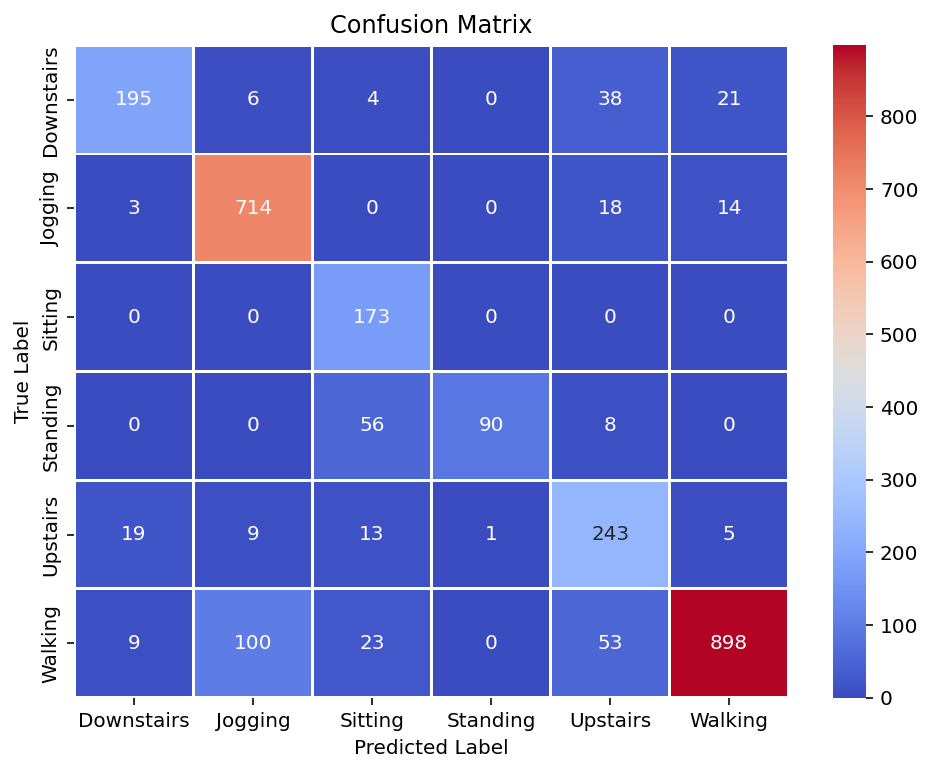

              precision    recall  f1-score   support

           0       0.86      0.74      0.80       264
           1       0.86      0.95      0.90       749
           2       0.64      1.00      0.78       173
           3       0.99      0.58      0.73       154
           4       0.68      0.84      0.75       290
           5       0.96      0.83      0.89      1083

    accuracy                           0.85      2713
   macro avg       0.83      0.82      0.81      2713
weighted avg       0.87      0.85      0.85      2713



In [ ]:
y_pred = model_rnn.predict(X_test)

# 원핫 인코딩을 레이블 인코딩으로 변환
max_y_pred = np.argmax(y_pred, axis=1)
show_results(y_test, max_y_pred)

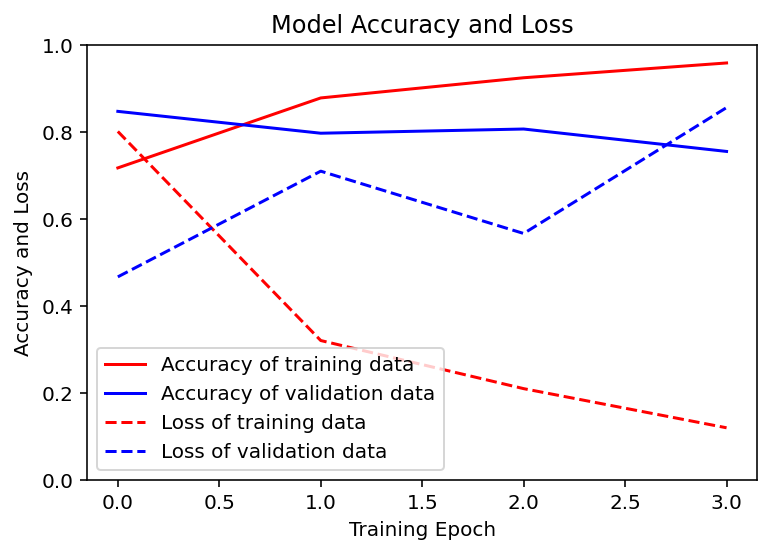

In [ ]:
show_4_graphs(history)